In [1]:
import hydra
import torch
from omegaconf import DictConfig, OmegaConf
from typing import Any, Dict, List, Optional, Tuple, Union
from deprecated import deprecated
from omegaconf import DictConfig
import numpy as np
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils import data

from src.data.process import DefaultTransform
from src.data.loader import BiTemporalDataset, load_levircd_sample
from src.models.commons.mask_process import binarize_mask, extract_object_from_batch
from src.models.segment_anything.utils.transforms import ResizeLongestSide
from src.models.segment_anything.utils.amg import build_point_grid
from src.commons.utils import *
from src.commons.utils_io import load_img
from src.commons.constants import PROJECT_PATH, DEVICE, IMG_SIZE

from hydra.core.global_hydra import GlobalHydra

In [2]:
from torch.profiler import profile, record_function, ProfilerActivity

### Batch iteration with prompt

In [3]:
params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape": 3,
    "loc": "center",
    "batch_size": 1,
}
ds = BiTemporalDataset(
        name="levir-cd",
        dtype="train",
        transform=DefaultTransform(),
        params=OmegaConf.create(params),
    )       

dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
        ) 

In [4]:
%%time
batch = next(iter(dloader))

2024-09-17 15:56:38,782 - INFO ::  Function remap_values Took 0.0014 seconds
2024-09-17 15:56:38,791 - INFO ::  Function extract_object_from_batch Took 0.7767 seconds
2024-09-17 15:56:38,921 - INFO ::  Function sample_candidates_shapes Took 0.0066 seconds
2024-09-17 15:56:38,924 - INFO ::  Function draw_center_point Took 0.0017 seconds
2024-09-17 15:56:38,926 - INFO ::  Function draw_center_point Took 0.0006 seconds
2024-09-17 15:56:38,927 - INFO ::  Function draw_center_point Took 0.0005 seconds
2024-09-17 15:56:38,929 - INFO ::  Function sample Took 0.9150 seconds


CPU times: user 44.1 s, sys: 1.13 s, total: 45.2 s
Wall time: 1.15 s


In [5]:
%%time
for i, batch in enumerate(dloader):
    if i == 9:
        break

2024-09-17 15:37:20,330 - INFO ::  Function extract_object_from_batch Took 0.7567 seconds
2024-09-17 15:37:20,481 - INFO ::  Function sample_candidates_shapes Took 0.0044 seconds
2024-09-17 15:37:20,484 - INFO ::  Function draw_center_point Took 0.0007 seconds
2024-09-17 15:37:20,486 - INFO ::  Function draw_center_point Took 0.0006 seconds
2024-09-17 15:37:20,487 - INFO ::  Function draw_center_point Took 0.0005 seconds
2024-09-17 15:37:20,489 - INFO ::  Function sample Took 0.9157 seconds
2024-09-17 15:37:21,543 - INFO ::  Function extract_object_from_batch Took 0.8081 seconds
2024-09-17 15:37:21,849 - INFO ::  Function sample_candidates_shapes Took 0.0049 seconds
2024-09-17 15:37:21,851 - INFO ::  Function draw_center_point Took 0.0006 seconds
2024-09-17 15:37:21,852 - INFO ::  Function draw_center_point Took 0.0005 seconds
2024-09-17 15:37:21,853 - INFO ::  Function draw_center_point Took 0.0003 seconds
2024-09-17 15:37:21,855 - INFO ::  Function sample Took 1.1203 seconds
2024-09-

CPU times: user 6min 59s, sys: 8.37 s, total: 7min 8s
Wall time: 9.15 s


### No prompts

In [6]:
params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape": 0,
    "loc": "center",
    "batch_size": 1,
}
ds = BiTemporalDataset(
        name="levir-cd",
        dtype="train",
        transform=DefaultTransform(),
        params=OmegaConf.create(params),
    )       

dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
        ) 

In [7]:
%%time
batch = next(iter(dloader))

CPU times: user 9.11 s, sys: 385 ms, total: 9.49 s
Wall time: 218 ms


In [8]:
%%time
for i, batch in enumerate(dloader):
    if i == 9:
        break

CPU times: user 1min 27s, sys: 2.72 s, total: 1min 30s
Wall time: 1.9 s


In [6]:
batch["label"].device

device(type='cpu')

### To GPU

In [19]:
import numba
print(numba.__version__)

0.60.0


In [33]:
import numpy as np
from numba import cuda
# TODO: keep old imp and wrap with numba
@cuda.jit
def connected_components_kernel(image, out, mask, num_iterations):
    x, y = cuda.grid(2)
    if x < image.shape[2] and y < image.shape[3]:
        for _ in range(num_iterations):
            max_val = out[0, 0, x, y]
            for dx in range(-1, 2):
                for dy in range(-1, 2):
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < image.shape[2] and 0 <= ny < image.shape[3]:
                        max_val = max(max_val, out[0, 0, nx, ny])
            out[0, 0, x, y] = max_val * mask[0, 0, x, y]

def connected_components_numba(image: np.ndarray, num_iterations: int = 100) -> np.ndarray:
    r"""Computes the Connected-component labelling (CCL) algorithm.

    Args:
        image: the binarized input image with shape (*, 1, H, W).
          The image must be in floating point with range [0, 1].
        num_iterations: the number of iterations to make the algorithm converge.

    Return:
        The labels image with the same shape of the input image.

    Example:
        >>> img = np.random.rand(2, 1, 4, 5)
        >>> img_labels = connected_components(img, num_iterations=100)
    """
    if not isinstance(image, np.ndarray):
        raise TypeError(f"Input image type is not a NumPy array. Got: {type(image)}")

    if not isinstance(num_iterations, int) or num_iterations < 1:
        raise TypeError("Input num_iterations must be a positive integer.")

    if len(image.shape) < 3 or image.shape[-3] != 1:
        raise ValueError(f"Input image shape must be (*,1,H,W). Got: {image.shape}")

    image_view = image.reshape(-1, 1, *image.shape[-2:])

    # precompute a mask with the valid values
    mask = (image_view == 1).astype(np.float32)

    # allocate the output array for labels
    out = np.arange(np.prod(image_view.shape)).reshape(image_view.shape).astype(np.float32)
    out[~mask.astype(bool)] = 0

    # Move data to GPU
    d_image = cuda.to_device(image_view)
    d_out = cuda.to_device(out)
    d_mask = cuda.to_device(mask)

    # Set up the grid and block dimensions
    threads_per_block = (16, 16)
    blocks_per_grid = (
        (image_view.shape[2] + threads_per_block[0] - 1) // threads_per_block[0],
        (image_view.shape[3] + threads_per_block[1] - 1) // threads_per_block[1]
    )

    # Launch the kernel
    connected_components_kernel[blocks_per_grid, threads_per_block](d_image, d_out, d_mask, num_iterations)

    # Copy the result back to the host
    result = d_out.copy_to_host()

    return result.reshape(image.shape)

In [28]:
import torch
import triton
import triton.language as tl

@triton.jit
def connected_components_kernel(
    image_ptr, labels_ptr, 
    H, W,
    BLOCK_SIZE: tl.constexpr
):
    # Compute the 2D position of the current thread
    pid = tl.program_id(0)
    x = pid % W
    y = pid // W

    # Load the image value and initial label
    image_val = tl.load(image_ptr + y * W + x)
    label = tl.load(labels_ptr + y * W + x)

    # Only process foreground pixels
    if image_val > 0.5:
        max_label = label
        # Check 8-connected neighborhood
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                nx, ny = x + dx, y + dy
                if 0 <= nx < W and 0 <= ny < H:
                    neighbor_label = tl.load(labels_ptr + ny * W + nx)
                    max_label = tl.maximum(max_label, neighbor_label)
        
        # Update the label
        tl.store(labels_ptr + y * W + x, max_label)

def connected_components(image: torch.Tensor, num_iterations: int = 100) -> torch.Tensor:
    """
    Computes the Connected-component labelling (CCL) algorithm using Triton.

    Args:
        image: the binarized input image with shape (B, 1, H, W).
               The image must be in floating point with range [0, 1].
        num_iterations: the number of iterations to make the algorithm converge.

    Returns:
        The labels image with the same shape as the input image.
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input image type is not a Tensor. Got: {type(image)}")

    if not isinstance(num_iterations, int) or num_iterations < 1:
        raise TypeError("Input num_iterations must be a positive integer.")

    if len(image.shape) != 4 or image.shape[1] != 1:
        raise ValueError(f"Input image shape must be (B,1,H,W). Got: {image.shape}")

    B, _, H, W = image.shape
    image = image.view(B, H, W)

    # Initialize labels
    labels = torch.arange(image.numel(), device=image.device, dtype=torch.float32).reshape(image.shape)
    labels = labels * (image > 0.5).float()  # Zero out background

    # Grid for Triton kernel
    grid = lambda meta: (H * W,)

    # Launch Triton kernel
    for _ in range(num_iterations):
        connected_components_kernel[grid](
            image.contiguous(), labels,
            H, W,
            BLOCK_SIZE=1024
        )

    return labels.view(B, 1, H, W)

In [16]:
def extract_object_from_batch(masks: torch.Tensor) -> torch.Tensor:

    
    def remap_values(remapping, x):
        index = torch.bucketize(x.ravel(), remapping[0])
        return remapping[1][index].reshape(x.shape)
        
    # Ensure the input is on GPU
    if not masks.is_cuda:
        masks = masks.cuda()
    
    # Normalize to [0, 1]
    masks = masks.float() / masks.max()
    
    # Apply connected components
    labels_masks = connected_components(masks.unsqueeze(1))
    uniques = torch.unique(labels_masks)
    # Labels from K.connected_component are not 0-index based and sequential integers
    # Need a mapping for one-hot
    remapping = uniques, torch.arange(end=len(uniques), device=labels_masks.device)
    remapped_batch = remap_values(remapping, labels_masks)
    # B x H x W => B x N x H x W
    masks = F.one_hot(remapped_batch.long(), len(uniques)).permute(0, 3, 1, 2)
    # remove background mask, i.e no-change
    masks = masks[
        :,
        1:,
        :,
    ]

    if masks.shape[1] == 0:
        # no object found in batch
        # return B x 1 x H x W zeros masks
        return torch.zeros(masks.shape[0], 1, *masks.shape[-2:])

    return masks

In [34]:
n_point_per_shape = 1
loc = "random"
n_shape = 3
sampler = PointSampler()

label_torch = torch.tensor(label, dtype=torch.float32)
if torch.cuda.is_available():
    label_torch = label_torch.cuda()


In [41]:
label = np.expand_dims(label, axis=0)

In [44]:
%%time
# with numba
shapes = connected_components_numba(label)

CPU times: user 44.9 ms, sys: 20.1 ms, total: 64.9 ms
Wall time: 63.4 ms


In [ ]:
df = load_levircd_sample(None, data_type="test", seed=42)

In [47]:
%%time
shapes = []
for i in range(100):
    path_label,path_A, path_B = df.iloc[i]
    label = load_img(path_label)
    label = np.expand_dims(label, axis=0)
    shapes.append(connected_components_numba(label))

CPU times: user 2.56 s, sys: 1.03 s, total: 3.59 s
Wall time: 3.59 s


In [55]:
np.sum(shapes)

0.0

In [ ]:
%%time
for i in range(100):
    path_label,path_A, path_B = df.iloc[i]
    label = load_img(path_label)
    label = np.expand_dims(label, axis=0)
    shapes = connected_components_numba(label)

In [5]:
# ds_name = "levir-cd"
# device = "cpu"
# batch_size = 1
# ds_type = "test"

# fname=None
# fidx=100

# exp_name = "adapter_concat_bce_lrx10-4_shuffle"

# if not any([fname, fidx]):
#     raise ValueError("Please provide at least a sample name or an sample index")
# # priority to fname
# if fname is not None:
#     fidx = ds.get_from_name(fname, return_sample=False)
# # TODO: allow indices sequence
# if isinstance(fidx, int): fidx = [fidx]


# cfg, data_module, module = load_exp(exp_name)
# ds = get_ds(ds_type, data_module)
# sub_dl = data.DataLoader(data.Subset(ds, fidx), batch_size=1, shuffle=False)
# batch = next(iter(sub_dl))

In [22]:
class PointSampler:
    """Prompt sampler - restricted to points
    
    Each generated points is under coordinates format (X,Y) in pixels.
    """
    MIN_AREA = 25
    
    def __init__(self):
        self._register_sample_method = {
            "random": self.draw_random_point,
            "center": self.draw_center_point,
        }

    def sample_candidates_shapes(self, shapes: torch.Tensor, n_shape: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # assign equals weights
        probs = torch.ones(shapes.shape[0]) / shapes.shape[0]
        # Sample the shapes
        id_candidates_shapes = torch.multinomial(
            probs,
            n_shape,
            # we sample with replacement to keeping same tensor dimensions over batch if not enough shapes
            replacement=False if (shapes.shape[0] >= n_shape) else True,
        )
        # get the coord of the pixels shapes (M x 3) - M number of not zeros pixels
        coords_candidates = torch.nonzero(shapes[id_candidates_shapes]).to(torch.float)
        return coords_candidates, id_candidates_shapes
    

    def sample(self, mask: torch.Tensor,  n_point_per_shape: int, loc: str, n_shape: int):
        """
        Sample m points over n random shape
        Return new label if a subset of shapes (n_shape) is selected
        """

        if loc not in list(self._register_sample_method):
            raise ValueError(
                f"loc method not valid. Valid values for loc : {list(self._register_sample_method)}"
            )
        if not n_shape:
            raise ValueError("please provide n_shape to sample. One point per shape")
            
        if mask.ndim < 3:
            mask = mask.unsqueeze(0)
        # track id shapes if we a subset of shapes
        id_selected_shapes = None
        
        # extract shapes from mask - squeeze batch dimension
        shapes = extract_object_from_batch(mask).squeeze(0)
        # print("shape", shapes.shape)
        # filter on areas
        areas = torch.sum(shapes, dim=(1, 2))
        indices = torch.where(areas > self.MIN_AREA)[0]
        shapes = shapes[indices,:,:]

        # check if there is some shapes extracted - check sum for no-shapes return
        # check > 1 first for speed in case of shapes - return no shapes :  (1 x) 1 x H x W
        if shapes.shape[0] > 1 or torch.sum(shapes):
            # extract all shapes (max of batch) if there are not enough shapes
            # n_shape = min(n_shape,  shapes.shape[0]) # not good for diff batch size
            coords_candidates, id_selected_shapes = self.sample_candidates_shapes(shapes, n_shape)
            # first column of coords_candidates == index of shape
            # iterate over the shapes
            sample_coords = torch.cat(
                [
                    # mask coordinates based on shape index
                    # select only coordinates dims for _register_sample_method : [:, 1:] => (N, 2)
                    self._register_sample_method[loc](
                        coords_candidates[coords_candidates[:, 0] == s][:, 1:], n_point_per_shape
                    )
                    for s in torch.unique(coords_candidates[:, 0])
                ]
            )
            # simulate point type (foreground / background) - foreground default
            labels_points = torch.ones(len(sample_coords))
        else:
            # empty return = sample random points
            #sample_coords = torch.zeros((n_shape*n_point_per_shape, 2), dtype=torch.float32) - 1000
            sample_coords = torch.as_tensor(np.random.randint(0, mask.shape[-1], size=(n_shape, 2)))
            # label - 1
            labels_points = torch.zeros(len(sample_coords)) - 1

        return sample_coords, labels_points

    def draw_random_point(self, shape, n_point):
        """draw one random point from shape"""
        idx = torch.multinomial(
            torch.ones(shape.shape[0], dtype=torch.float), num_samples=n_point
        )
        # invert pixels coords to (x, y) format
        return torch.flip(shape[idx], dims=(1,))

    def draw_center_point(self, shape, n_point):
        """
        Sample approximation center. Proxy for hard concave object where "natural center" (simple average) doesn't belong to the shape.
        shape : (M, 2) : (shape's pixels, px coordinates dim)
        """
        # proxy for hard concave object
        visible_center = torch.mean(shape, dim=0).to(int)
        # euclidean distance
        dist_center = torch.cdist(visible_center.unsqueeze(0).to(torch.fldeviceoat), shape, p=2.).view(-1)
        idx = torch.nonzero(dist_center).view(-1)
        dist_center, shape = dist_center[idx], shape[idx,...]
        # sample point from inverse distance weighting => in favor of "closest center" point - take first 50 pts arbitrary
        # values, indices  = torch.topk(dist_center, min(50, dist_center.shape[0]), largest=False, sorted=True)
        # values, indices = values.view(-1), indices.view(-1)
        idx = torch.multinomial(
            1/dist_center, num_samples=n_point
        )
        # flip to convert to (x, y) format
        return torch.flip(shape[idx], dims=(1,))

    def profiled_sample(self, mask: torch.Tensor, n_point_per_shape: int, loc: str, n_shape: int):
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                     record_shapes=True,
                     profile_memory=True) as prof:
            with record_function("sample"):
                result = self.sample(mask, n_point_per_shape, loc, n_shape)
        
        print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
        #print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
        prof.export_chrome_trace("trace_chrome" + str(prof.step_num) + ".json")

In [10]:
df = load_levircd_sample(None, data_type="test", seed=42)

In [11]:
idx=12
path_label,path_A, path_B = df.iloc[idx]
label = load_img(path_label)

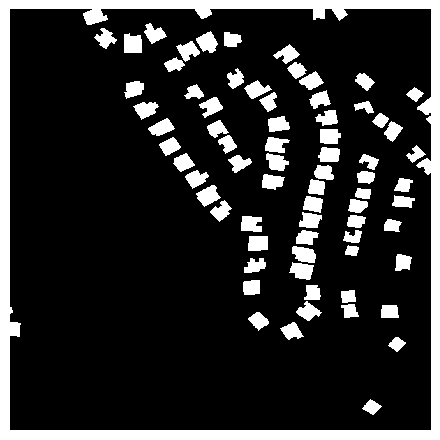

In [12]:
show_img(label)

In [14]:

label_torch = torch.tensor(label, dtype=torch.float32)
n_point_per_shape = 1
loc = "random"
n_shape = 3
sampler = PointSampler()

if torch.cuda.is_available():
    label_torch = label_torch.cuda()

sampler.profiled_sample(label_torch, n_point_per_shape, loc, n_shape)

[W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
[W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
2024-09-17 14:56:31,310 - INFO ::  Function extract_object_from_batch Took 0.2177 seconds


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           sample        31.32%      88.540ms       100.00%     282.721ms     282.721ms       5.965ms         2.11%     282.734ms     282.734ms          12 b     -13.41 Kb         512 b      -6.83 Gb             1  
                 aten::max_pool2d         2.29%       6.464ms         

In [17]:
n_point_per_shape = 1
loc = "random"
n_shape = 3
sampler = PointSampler()

label_torch = torch.tensor(label, dtype=torch.float32)
if torch.cuda.is_available():
    label_torch = label_torch.cuda()


In [18]:
%%time
# with triton
result = sampler.sample(label_torch, n_point_per_shape, loc, n_shape)

CompilationError: at 11:117:
def connected_components_kernel(image_ptr, out_ptr, mask_ptr, H, W, num_iterations, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(0)
    row = pid // W
    col = pid % W

    if row < H and col < W:
        idx = row * W + col
        for _ in range(num_iterations):
            max_val = tl.max(tl.load(out_ptr + idx - W - 1), tl.load(out_ptr + idx - W), tl.load(out_ptr + idx - W + 1),
                             tl.load(out_ptr + idx - 1), tl.load(out_ptr + idx), tl.load(out_ptr + idx + 1),
                             tl.load(out_ptr + idx + W - 1), tl.load(out_ptr + idx + W), tl.load(out_ptr + idx + W + 1))
                                                                                                                     ^

In [16]:
%%time
# no opti
result = sampler.sample(label, n_point_per_shape, loc, n_shape)

2024-09-17 14:56:53,649 - INFO ::  Function extract_object_from_batch Took 0.7384 seconds


CPU times: user 43.2 s, sys: 981 ms, total: 44.2 s
Wall time: 923 ms


In [ ]:
%%time
result = sampler.sample(label, n_point_per_shape, loc, n_shape)